# Demo object and attribute predictions


### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
import pylab
from skimage import transform
# display plots in this notebook
%matplotlib inline

import os

# set display defaults
plt.rcParams['figure.figsize'] = (12, 9)        # small images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [2]:
# Change dir to caffe root or prototxt database paths won't work wrong
import os
print os.getcwd()
os.chdir('..')
print os.getcwd()

/home/chenlong/workspace/test/bottom-up-attention/tools
/home/chenlong/workspace/test/bottom-up-attention


In [4]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
sys.path.insert(0, './caffe/python/')
sys.path.insert(0, './lib/')
sys.path.insert(0, './tools/')

import caffe

In [5]:
data_path = './data/genome/1600-400-20'

# Load classes
classes = ['__background__']
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        classes.append(object.split(',')[0].lower().strip())

# Load attributes
attributes = ['__no_attribute__']
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for att in f.readlines():
        attributes.append(att.split(',')[0].lower().strip())

In [11]:
# Check object extraction
from fast_rcnn.config import cfg, cfg_from_file
from fast_rcnn.test import im_detect,_get_blobs
from fast_rcnn.nms_wrapper import nms
import cv2

GPU_ID = 1   # if we have multiple GPUs, pick one 
caffe.set_device(GPU_ID)  
caffe.set_mode_gpu()
net = None
cfg_from_file('experiments/cfgs/faster_rcnn_end2end_resnet.yml')

weights = 'data/faster_rcnn_models/resnet101_faster_rcnn_final.caffemodel'
prototxt = 'models/vg/ResNet-101/faster_rcnn_end2end_final/test.prototxt'

net = caffe.Net(prototxt, caffe.TEST, weights=weights)

boxes=13


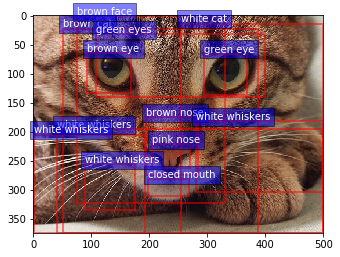

In [12]:

im_file = 'data/demo/000542.jpg'

###########################
# Similar to get_detections_from_im
conf_thresh=0.4
min_boxes=10
max_boxes=20

im = cv2.imread(im_file)
scores, boxes, attr_scores, rel_scores = im_detect(net, im)

# Keep the original boxes, don't worry about the regression bbox outputs
rois = net.blobs['rois'].data.copy()
# unscale back to raw image space
blobs, im_scales = _get_blobs(im, None)

cls_boxes = rois[:, 1:5] / im_scales[0]
cls_prob = net.blobs['cls_prob'].data
attr_prob = net.blobs['attr_prob'].data
pool5 = net.blobs['pool5_flat'].data

# Keep only the best detections
max_conf = np.zeros((rois.shape[0]))
for cls_ind in range(1,cls_prob.shape[1]):
    cls_scores = scores[:, cls_ind]
    dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis])).astype(np.float32)
    keep = np.array(nms(dets, cfg.TEST.NMS))
    max_conf[keep] = np.where(cls_scores[keep] > max_conf[keep], cls_scores[keep], max_conf[keep])

keep_boxes = np.where(max_conf >= conf_thresh)[0]
if len(keep_boxes) < min_boxes:
    keep_boxes = np.argsort(max_conf)[::-1][:min_boxes]
elif len(keep_boxes) > max_boxes:
    keep_boxes = np.argsort(max_conf)[::-1][:max_boxes]
############################

im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

boxes = cls_boxes[keep_boxes]
objects = np.argmax(cls_prob[keep_boxes][:,1:], axis=1)
attr_thresh = 0.1
attr = np.argmax(attr_prob[keep_boxes][:,1:], axis=1)
attr_conf = np.max(attr_prob[keep_boxes][:,1:], axis=1)

for i in range(len(keep_boxes)):
    bbox = boxes[i]
    if bbox[0] == 0:
        bbox[0] = 1
    if bbox[1] == 0:
        bbox[1] = 1
    cls = classes[objects[i]+1]
    if attr_conf[i] > attr_thresh:
        cls = attributes[attr[i]+1] + " " + cls
    plt.gca().add_patch(
        plt.Rectangle((bbox[0], bbox[1]),
                      bbox[2] - bbox[0],
                      bbox[3] - bbox[1], fill=False,
                      edgecolor='red', linewidth=2, alpha=0.5)
            )
    plt.gca().text(bbox[0], bbox[1] - 2,
                '%s' % (cls),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=10, color='white')
print 'boxes=%d' % (len(keep_boxes))